In [67]:
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

DIR = '/mnt/ml-team/minerva/open-solutions/home-credit'
description = pd.read_csv(os.path.join(DIR,'data/HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/application_train.csv'))
bureau = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/bureau.csv'))

In [77]:
description[description['Row'] == 'DAYS_CREDIT'].Description.tolist()

['How many days before current application did client apply for Credit Bureau credit']

In [5]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


# Preprocessing
## Solution 3

In [6]:
(bureau['AMT_CREDIT_SUM'] == 0).sum()

66582

This shows that imputing with nan with 0 is probably a bad idea

# Feature Engineering
## Solution 3
### Hand crafted features

In [57]:
bureau.sort_values('SK_ID_BUREAU', ascending=True, inplace=True)
group_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])

In [58]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,bureau_credit_active_binary,bureau_active_loans_percentage
1706035,166497,5000000,Closed,currency 1,-2918,0,-2613.0,-2639.0,NaN,0,...,NaN,0.0,Consumer credit,-2512,NaN,NaN,NaN,NaN,0,NaN
1706036,166497,5000001,Closed,currency 1,-1015,0,-831.0,-891.0,2223.855,0,...,0.0,0.0,Consumer credit,-891,NaN,NaN,NaN,NaN,0,NaN
61505,166497,5000002,Closed,currency 1,-149,0,-26.0,-26.0,0.000,0,...,0.0,0.0,Consumer credit,-23,NaN,8.0,2.0,4.000000,0,0.625
61506,166497,5000003,Closed,currency 1,-135,0,230.0,-42.0,0.000,0,...,0.0,0.0,Consumer credit,-42,NaN,4.0,3.0,1.333333,0,0.250
61507,166497,5000004,Active,currency 1,-47,0,320.0,NaN,0.000,0,...,0.0,0.0,Consumer credit,-17,NaN,5.0,2.0,2.500000,1,0.800


In [25]:
group_SK_ID_CURR['DAYS_CREDIT'].agg('count').reset_index()[['DAYS_CREDIT','SK_ID_CURR']].sort_values('SK_ID_CURR')


,DAYS_CREDIT,SK_ID_CURR
0,7,100001
1,8,100002
2,4,100003
3,2,100004
4,3,100005
5,1,100007
6,3,100008
7,18,100009
8,2,100010
9,4,100011


In [60]:
bureau['bureau_number_of_loan_types'] = group_SK_ID_CURR['DAYS_CREDIT'].agg('count').reset_index()['DAYS_CREDIT']

bureau['bureau_number_of_loan_types'] = group_SK_ID_CURR['CREDIT_TYPE'].agg('nunique').reset_index()['CREDIT_TYPE']

# bureau['bureau_average_of_past_loans_per_type'] = \
#     bureau['bureau_number_of_past_loans'] / bureau['bureau_number_of_loan_types']

# bureau['bureau_credit_active_binary'] = bureau.apply(lambda x: int(x.CREDIT_ACTIVE != 'Closed'), axis=1)
# bureau['bureau_active_loans_percentage'] = bureau.groupby(
#     by=['SK_ID_CURR'])['bureau_credit_active_binary'].agg('mean').reset_index()['bureau_credit_active_binary']

# bureau['bureau_days_credit_diff'] = bureau.groupby(
#     by=['SK_ID_CURR']).apply(
#     lambda x: x.sort_values(['DAYS_CREDIT'], ascending=False)).reset_index(drop=True)['DAYS_CREDIT']
# bureau['bureau_days_credit_diff'] *= -1
# bureau['bureau_days_credit_diff'] = bureau.groupby(by=['SK_ID_CURR'])['bureau_days_credit_diff'].diff()
# bureau['bureau_days_credit_diff'] = bureau['bureau_days_credit_diff'].fillna(0)

# bureau['bureau_credit_enddate_binary'] = bureau.apply(lambda x: int(x.DAYS_CREDIT_ENDDATE > 0), axis=1)
# bureau['bureau_credit_enddate_percentage'] = bureau.groupby(
#     by=['SK_ID_CURR'])['bureau_credit_enddate_binary'].agg('mean').reset_index()['bureau_credit_enddate_binary']

# group = bureau[bureau['bureau_credit_enddate_binary'] == 1].groupby(
#     by=['SK_ID_CURR']).apply(
#     lambda x: x.sort_values(['DAYS_CREDIT_ENDDATE'], ascending=True)).reset_index(drop=True)
# group['bureau_days_enddate_diff'] = group.groupby(by=['SK_ID_CURR'])['DAYS_CREDIT_ENDDATE'].diff()
# group['bureau_days_enddate_diff'] = group['bureau_days_enddate_diff'].fillna(0).astype('uint32')

# bureau = bureau.merge(group[['bureau_days_enddate_diff', 'SK_ID_BUREAU']], on=['SK_ID_BUREAU'], how='left')
# bureau['bureau_average_enddate_future'] = bureau.groupby(
#     by=['SK_ID_CURR'])['bureau_days_enddate_diff'].agg('mean').reset_index()['bureau_days_enddate_diff']

# bureau['bureau_total_customer_debt'] = bureau.groupby(
#     by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].agg('sum').reset_index()['AMT_CREDIT_SUM_DEBT']
# bureau['bureau_total_customer_credit'] = bureau.groupby(
#     by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].agg('sum').reset_index()['AMT_CREDIT_SUM']
# bureau['bureau_debt_credit_ratio'] = \
#     bureau['bureau_total_customer_debt'] / bureau['bureau_total_customer_credit']

# bureau['bureau_total_customer_overdue'] = bureau.groupby(
#     by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].agg('sum').reset_index()['AMT_CREDIT_SUM_OVERDUE']
# bureau['bureau_overdue_debt_ratio'] = bureau['bureau_total_customer_overdue'] / bureau[
#     'bureau_total_customer_debt']

# bureau['bureau_average_creditdays_prolonged'] = bureau.groupby(
#     by=['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].agg('mean').reset_index()['CNT_CREDIT_PROLONG']

# self.

In [61]:
bureau_engineered_numerical_columns = ['bureau_number_of_past_loans',
                             'bureau_number_of_loan_types',
#                              'bureau_average_of_past_loans_per_type',
#                              'bureau_active_loans_percentage',
#                              'bureau_days_credit_diff',
#                              'bureau_credit_enddate_percentage',
#                              'bureau_days_enddate_diff',
#                              'bureau_average_enddate_future',
#                              'bureau_total_customer_debt',
#                              'bureau_total_customer_credit',
#                              'bureau_debt_credit_ratio',
#                              'bureau_total_customer_overdue',
#                              'bureau_average_creditdays_prolonged'
                             ]

In [62]:
bureau_features = bureau[bureau_engineered_numerical_columns + ['SK_ID_CURR']]

In [63]:
bureau_ONE = bureau_features[bureau_features['SK_ID_CURR']==215354]

In [64]:
bureau_ONE

,bureau_number_of_past_loans,bureau_number_of_loan_types,SK_ID_CURR
225157,4.0,2.0,215354
225158,1.0,1.0,215354
225159,4.0,1.0,215354
225160,7.0,2.0,215354
0,7.0,1.0,215354
1,8.0,2.0,215354
2,4.0,2.0,215354
3,2.0,1.0,215354
4,3.0,2.0,215354
5,1.0,1.0,215354


In [52]:
bureau_features.drop_duplicates(subset=['SK_ID_CURR']).head()

,bureau_number_of_past_loans,bureau_number_of_loan_types,bureau_average_of_past_loans_per_type,SK_ID_CURR
1705297,NaN,NaN,NaN,134450
1705289,NaN,NaN,NaN,387585
1705285,NaN,NaN,NaN,101681
1705276,NaN,NaN,NaN,377688
1705274,NaN,NaN,NaN,224416


In [18]:
application = application.merge(bureau_features,
                                left_on=['SK_ID_CURR'],
                                right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')

MergeError: Merge keys are not unique in right dataset; not a one-to-one merge

In [ ]:
X = X.merge(self.credit_card_features,
            left_on=self.id_columns[0],
            right_on=self.id_columns[1],
            how='left',
            validate='one_to_one')

In [11]:
bureau_eng = bureau[engineered_numerical_columns + ['TARGET']]
bureau_eng_corr = abs(bureau_eng.corr())

KeyError: "['TARGET'] not in index"

In [44]:
X_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                       1.000000
ext_sources_mean             0.222052
credit_to_goods_ratio        0.069427
car_to_birth_ratio           0.048824
days_employed_percentage     0.042206
phone_to_birth_ratio         0.033991
credit_to_annuity_ratio      0.032102
car_to_employ_ratio          0.030553
children_ratio               0.021223
annuity_income_percentage    0.014265
payment_rate                 0.012704
income_per_child             0.012529
credit_to_income_ratio       0.007727
income_per_person            0.006571
phone_to_employ_ratio        0.004562
income_credit_percentage     0.001817
Name: TARGET, dtype: float64

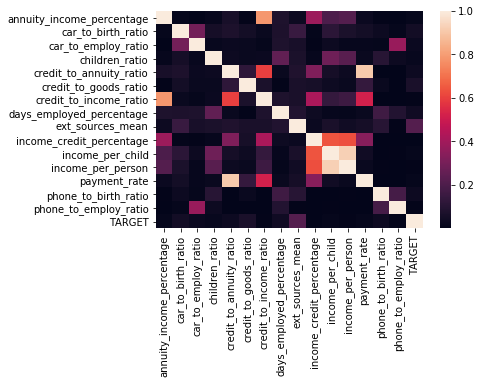

In [45]:
sns.heatmap(X_eng_corr, 
            xticklabels=X_eng_corr.columns,
            yticklabels=X_eng_corr.columns)

### Aggregation features

In [46]:
AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
]

In [50]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = X.groupby(groupby_cols)
    for select, agg in specs:
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        X = X.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

In [54]:
X_agg = X[groupby_aggregate_names + ['TARGET']]
X_agg_corr = abs(X_agg.corr())

In [55]:
X_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                                                      1.000000
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1                0.089964
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_2    0.089235
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1    0.086676
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_1                                       0.083520
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_2                                       0.082742
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_ELEVATORS_AVG               0.078057
OCCUPATION_TYPE_mean_EXT_SOURCE_1                                                           0.076587
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_AMT_REQ_CREDIT_BUREAU_YEAR                         0.074528
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_YEARS_BUILD_AVG                                   

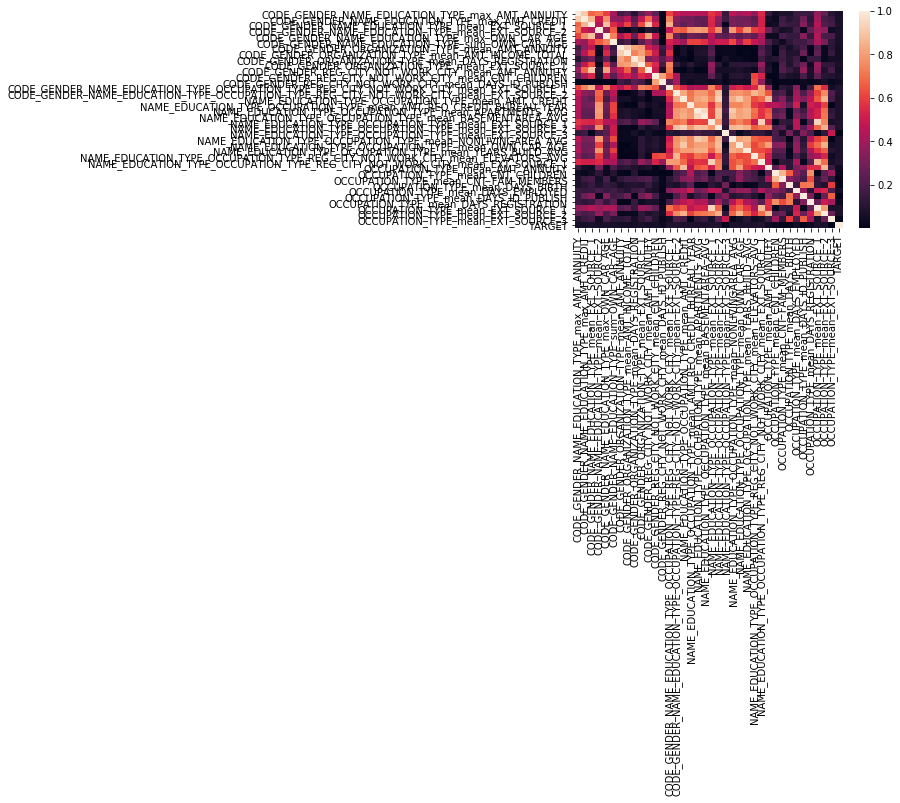

In [57]:
sns.heatmap(X_agg_corr, 
            xticklabels=X_agg_corr.columns,
            yticklabels=X_agg_corr.columns)

## Solution 4 TODO
### Hand crafted features
* Explore other ext_sources features
* Explore unemployed feature